
# Week 5 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [3]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

Cell 2:

# ***What?*** 
<200 words
Group members: Yilun Xu, Yiheng Zhu & Qiong Li

The main purpose of this research project is to do public opinion analysis on COVID 19, and the targeted groups are mainly citizens and the media. I will use Twitter related to COVID 19 in March and before to analyze the public's thoughts on the epidemic and their changes. At the same time, I will use the articles published by CBC related to the epidemic as a data set for researching media views. To be specific, methods about Measuring Meaning & Counting Words, Sampling, Crowd-Sourcing & Reliability, Classifying Meanings & Documents and Deep Classification, Embedding & Text Generation will be used. I want to explore: 1. How people and CBC consider COVID 19 each day, 2. The changes in attitudes towards COVID 19 on Twitter and CBC.


Cell 3:

## ***Why?***
<200 words
COVID 19 is seriously affecting our lives. I think the process of studying the public and mainstream media's understanding of this epidemic and the changes in their attitudes can provide a reference for politicians to formulate policies. At the same time, my personal research interest lies in the intersection of decision-making systems, computing methods, and urban science. As a "black swan" in 2020, COVID 19 has brought huge challenges to the emergency management system and city management system of all countries in the world. I hope to tap into the experience of building an urban emergency management system from the understanding of COVID19 by people and mainstream media. As Bill Gates said, we may face more pandemics in the future. Then the lessons and lessons learned from this COVID 19 must be reflected in the future urban design and management system design.
Cell 4:

## ***How?***
<400 words

Cell 5:
We use 4 methods in this project. First, we sample our dataset. Then use social network, embedding and cluster to analysis our text data.


## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

Cell 6:

## ***Which (words)?***
<300 words
I hope to understand the views of citizens and "opinion leaders" on COVID 19 from these data sets and use this as a basis to infer their response to urban emergency crises (including natural disasters, epidemics, etc.). Fortunately, whether it is a Twitter dataset or a CBC article dataset, their data volume is very large and relatively complete, which allows us to draw effective conclusions. There are also some flaws in these data sets. For example, some people prefer Twitter, and they may prefer to tweet, and the opinions of people who are not used to tweet will be relatively ignored. In addition, we only studied CBC. Therefore, our conclusion should be limited to discussing information learned from Twitter and CBC articles. In the future, we can also choose Facebook, Ins, and other popular social media in other countries (such as WeChat, Weibo, etc. in China), and other mainstream media like Washington Post, CCTV, Times, etc. After studying a more extensive data set, we may be able to infer the views of ordinary people and "opinion leaders" on the social emergency crises represented by COVID 19 and provide a reference for future policy formulation in response to these crises.

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [32]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '/Users/sunny/Documents/CCA Spring 2020/Content-Analysis-2020-master/data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [33]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


In [34]:
import os

In [35]:
os.path

<module 'posixpath' from '/Users/sunny/opt/anaconda3/lib/python3.7/posixpath.py'>

We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [36]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [37]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [38]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [39]:
newsgroupsVects[500:510,600:620].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [56]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [57]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [58]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [59]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [60]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [61]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [62]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [63]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [64]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [65]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [66]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,wald_predictions,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,4,3
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,4,3
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,4,3
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,4,3
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,4,3
...,...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,4,3
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2,1
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2,1
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,4,3


We can also look at the distinguishing features in each cluster:

In [67]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 price
 email


Cluster 1:
 car
 cars
 engine
 like
 just
 good
 think
 don
 new
 dealer


Cluster 2:
 window
 server
 use
 motif
 widget
 using
 program
 application
 like
 code


Cluster 3:
 know
 thanks
 mac
 just
 does
 drive
 like
 apple
 don
 problem




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [68]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [69]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [70]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

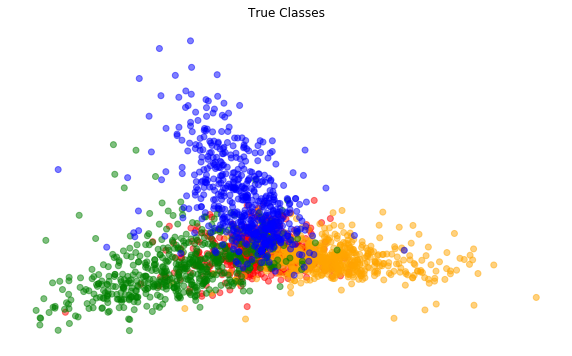

In [71]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

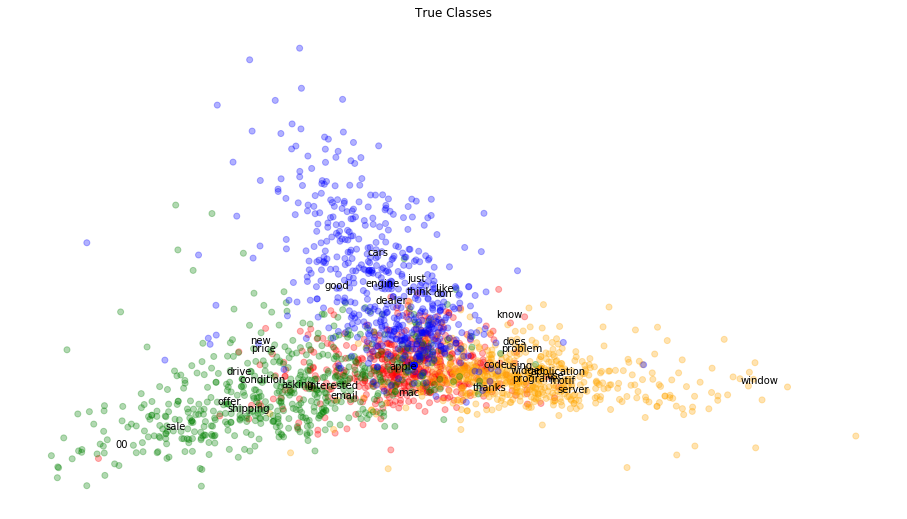

In [72]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [73]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

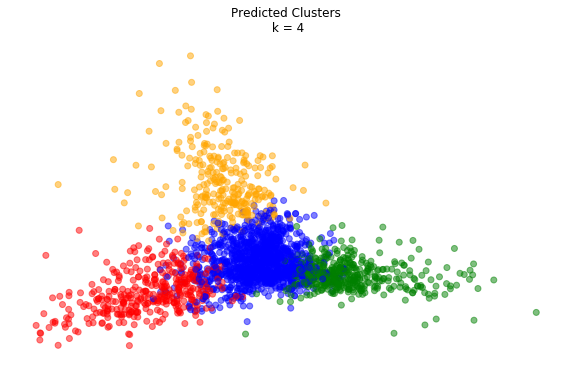

In [74]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [75]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [76]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


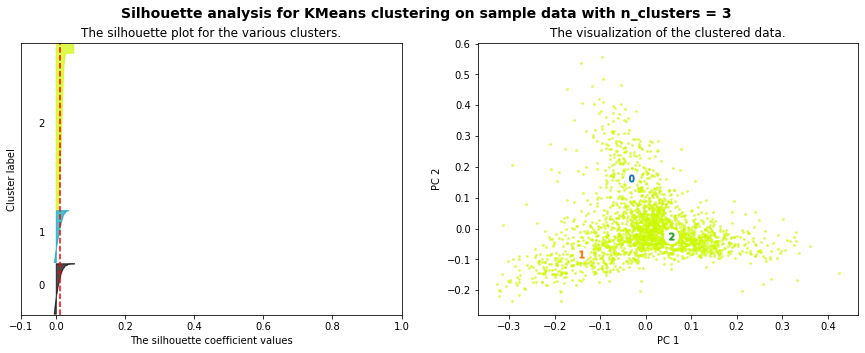

For n_clusters = 3, The average silhouette_score is : 0.013


In [77]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


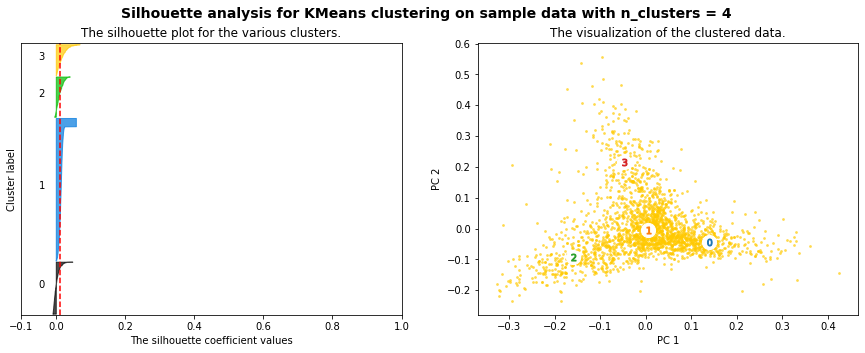

For n_clusters = 4, The average silhouette_score is : 0.012


In [78]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


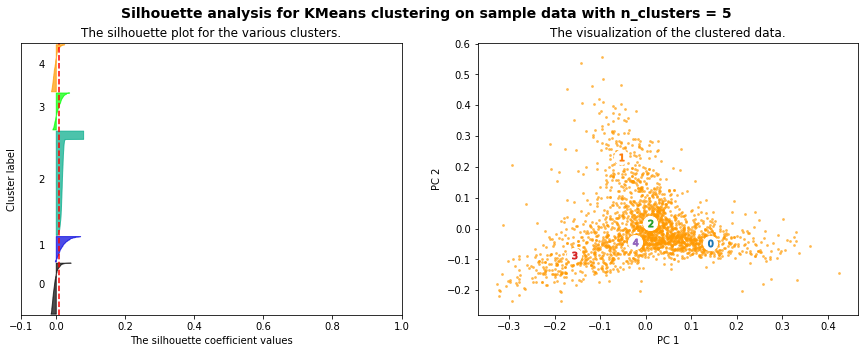

For n_clusters = 5, The average silhouette_score is : 0.010


In [79]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


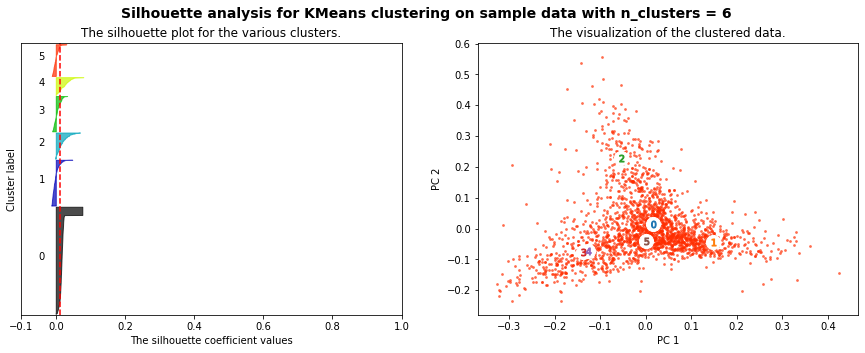

For n_clusters = 6, The average silhouette_score is : 0.011


In [80]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [81]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud_2020.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("/Users/sunny/Documents/CCA Spring 2020/Content-Analysis-2020-master/data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [82]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [83]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [84]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [85]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [86]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

And visualize:

In [87]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

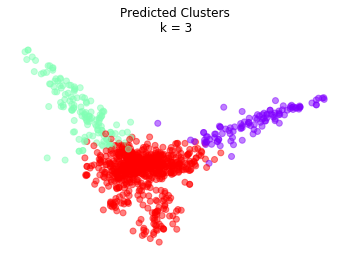

In [88]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [89]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
...,...,...,...,...,...,...,...,...
994,995,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy13.txt,raw/Kennedy/18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,Kennedy,2
995,996,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy14.txt,raw/Kennedy/18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,Kennedy,2
996,997,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy0.txt,raw/Kennedy/18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
997,998,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy1.txt,raw/Kennedy/18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [5]:
review = pandas.read_csv("/Users/sunny/Documents/CCA Spring 2020/final project/amazon-music-reviews/Musical_instruments_reviews.csv")

In [6]:
review

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"
...,...,...,...,...,...,...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","Great, just as expected. Thank to all.",5.0,Five Stars,1405814400,"07 20, 2014"
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014"
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4.0,Good for coated.,1405987200,"07 22, 2014"
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,1404172800,"07 1, 2014"


In [7]:
# TFIDF vectoriser
review_vectoriser = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
review_Vects = review_vectoriser.fit_transform(review['summary'])

In [8]:
review_vectoriser.stop_words_

{'handiest',
 'coz',
 'rules',
 'v67g',
 'bizarre',
 'sit',
 'responsively',
 'crackling',
 'updated',
 'wireless',
 '400',
 'flatwounds',
 'private',
 'tungsol',
 'arsenal',
 'uffff',
 'windage',
 'squeeze',
 'adults',
 'toaster',
 'anyting',
 'dimensions',
 'thi',
 'hell',
 'chance',
 'kicks',
 'provide',
 'vibrato',
 '514ce',
 'neccessity',
 'game',
 'rivals',
 'definately',
 'plugged',
 'chromey',
 'hour',
 'plonking',
 'passing',
 'town',
 'slip',
 'recorders',
 'tastes',
 'pieces',
 'clarity',
 'hats',
 'bye',
 'temporary',
 'celluloid',
 '046',
 'flute',
 'stool',
 'jake',
 'whoa',
 'abalone',
 'plant',
 'springs',
 'sweeeet',
 'juice',
 'bed',
 'mogami',
 'app',
 '1x3',
 'nitrocellulose',
 'panet',
 'sounded',
 'sol',
 'ounces',
 'tea',
 'pockets',
 'rates',
 'sliced',
 'tighten',
 'proud',
 'badly',
 'resolution',
 'finishes',
 'boutique',
 'ole',
 'harmonist',
 'bugera',
 'adaptable',
 'miracle',
 'competition',
 'apogee',
 'profesional',
 'jackson',
 'beer',
 'future',
 'arr

 3 clusters

In [9]:
num_cluster = 3
km = sklearn.cluster.KMeans(n_clusters=num_cluster, init='k-means++')

In [10]:
km.fit(review_Vects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [11]:
review['kmeans_prediction3'] = km.labels_

In [12]:
terms =review_vectoriser.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_cluster):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 good
 price
 strings
 quality
 product
 cable
 picks
 value
 stand
 pretty
 stuff
 sound
 mic
 tuner
 capo
 cables
 strap
 really
 great
 guitar


Cluster 1:
 nice
 works
 best
 guitar
 perfect
 love
 excellent
 strings
 does
 awesome
 stand
 strap
 price
 just
 tuner
 picks
 like
 use
 quality
 job


Cluster 2:
 great
 price
 works
 product
 strings
 tuner
 pedal
 guitar
 stand
 little
 sound
 value
 picks
 strap
 money
 quality
 amp
 cable
 mic
 deal




In [13]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(review_Vects.toarray())
reduced_data = pca.transform(review_Vects.toarray())

In [14]:
# get distinguishing words to label
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [15]:
# set colors
colors = ['orange', 'green', 'blue']
colors_p = [colors[l] for l in km.labels_]

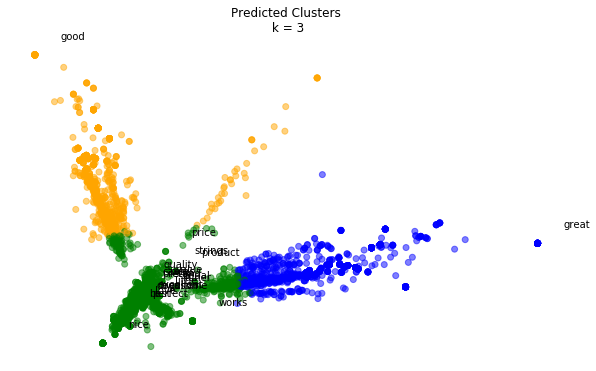

In [16]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(num_cluster))
plt.show()

Finding optimal cluster

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


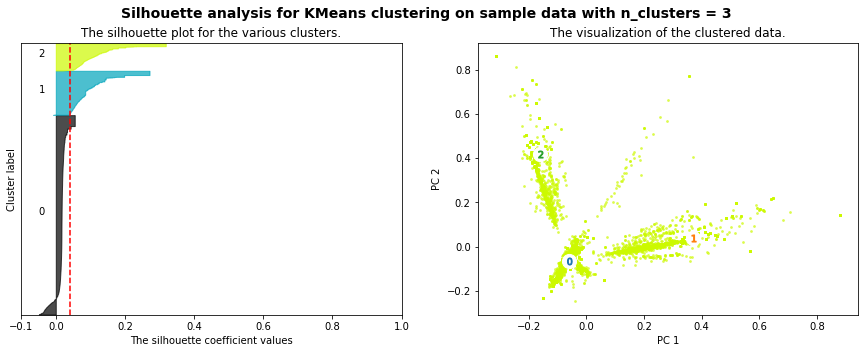

For n_clusters = 3, The average silhouette_score is : 0.042


In [19]:
review_silhouette = review_Vects.toarray()
plotSilhouette(3, review_silhouette)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


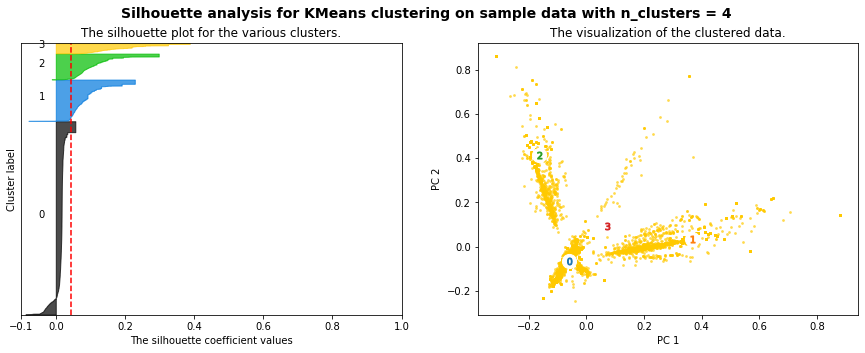

For n_clusters = 4, The average silhouette_score is : 0.044


In [20]:
plotSilhouette(4, review_silhouette)

In [21]:
def find_best_n(X):
    clusters = []
    s_avg = []
    for i in range(2, 10):
        clusterer = sklearn.cluster.KMeans(n_clusters=i, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
        clusters.append(i)
        s_avg.append(silhouette_avg)
        print("For {} clusters, average silhouette score is {}".format(i, silhouette_avg))
    plt.plot(clusters, s_avg)
    plt.show()

For 2 clusters, average silhouette score is 0.03168703620062431
For 3 clusters, average silhouette score is 0.04238552954947093
For 4 clusters, average silhouette score is 0.044424849163712685
For 5 clusters, average silhouette score is 0.05866743068207493
For 6 clusters, average silhouette score is 0.0675225455586406
For 7 clusters, average silhouette score is 0.06768303909973453
For 8 clusters, average silhouette score is 0.06610422691481252
For 9 clusters, average silhouette score is 0.06858857138179068


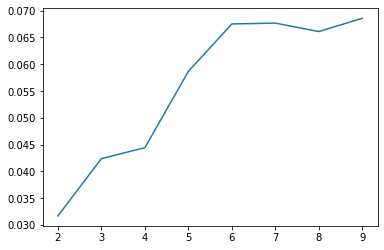

In [22]:
find_best_n(review_silhouette)

It seems that when we have 6 clusters, the silhouette score reach at the top and taper off later.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


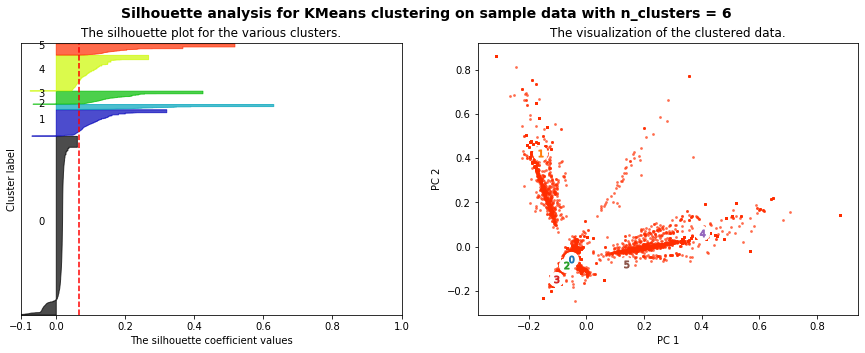

For n_clusters = 6, The average silhouette_score is : 0.068


In [24]:
plotSilhouette(6, review_silhouette)

In [25]:
num_cluster = 6
km_6 = sklearn.cluster.KMeans(n_clusters=num_cluster, init='k-means++')

In [27]:
km_6.fit(review_Vects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [28]:

terms = review_vectoriser.get_feature_names()
print("Top terms per cluster:")
order_centroids = km_6.cluster_centers_.argsort()[:, ::-1]
for i in range(num_cluster):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 nice
 best
 love
 excellent
 strings
 does
 awesome
 quality
 use
 tuner


Cluster 1:
 guitar
 great
 stand
 strings
 strap
 acoustic
 best
 electric
 picks
 good


Cluster 2:
 works
 great
 fine
 advertised
 good
 like
 simple
 just
 expected
 better


Cluster 3:
 perfect
 fit
 studio
 practice
 replacement
 price
 home
 tuner
 just
 guitar


Cluster 4:
 great
 price
 product
 strings
 tuner
 pedal
 little
 sound
 stand
 picks


Cluster 5:
 good
 price
 strings
 quality
 product
 picks
 cable
 value
 stuff
 stand




In [29]:
num_cluster=6
cmap = matplotlib.cm.get_cmap("nipy_spectral")
colors_p = [cmap(l/num_cluster) for l in km_6.labels_]

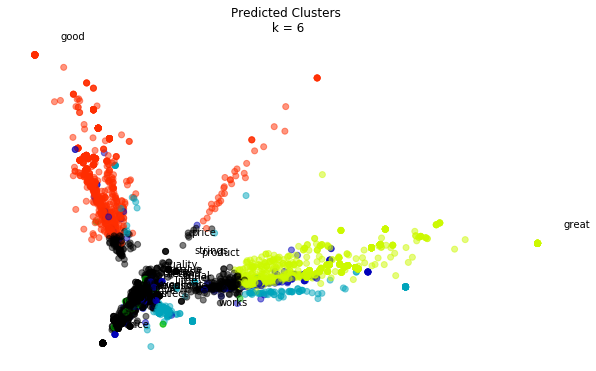

In [30]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(num_cluster))
plt.show()

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [42]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [43]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [44]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [45]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [46]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [47]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 76.        , 143.        ,   0.        ,   2.        ],
       [145.        , 200.        ,   0.        ,   3.        ],
       [148.        , 201.        ,   0.        ,   4.        ],
       [  5.        , 202.        ,   0.37033177,   5.        ],
       [ 54.        , 119.        ,   0.40914841,   2.        ],
       [ 10.        ,  44.        ,   0.44134524,   2.        ],
       [ 49.        , 112.        ,   0.45096656,   2.        ],
       [101.        , 204.        ,   0.4553535 ,   3.        ],
       [ 67.        , 206.        ,   0.4650683 ,   3.        ],
       [  2.        ,  46.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

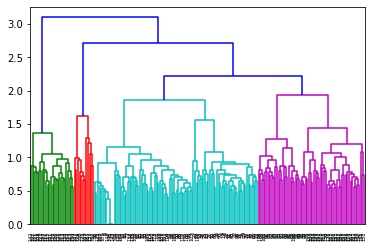

In [48]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

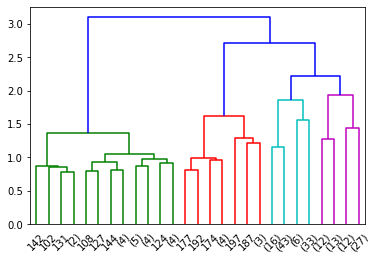

In [49]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [50]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4,
       4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4,
       4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3,
       3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 4, 4, 1, 4,
       4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 3, 2, 2, 2,
       4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4, 4, 4, 4, 2,
       4, 3], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [51]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [52]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,4
...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,4
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [90]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

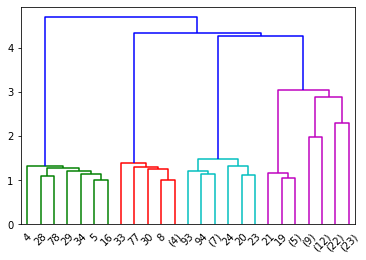

In [91]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [92]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [97]:
review_coocmat = review_Vects * review_Vects.T

<10261x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 24519 stored elements in Compressed Sparse Row format>

In [99]:
review_coocmat.setdiag(0)
#set the diagonal to 0 since we don't care how similar texts are to themselves
reviewlinkage_matrix_euclid = scipy.cluster.hierarchy.ward(review_coocmat.toarray())

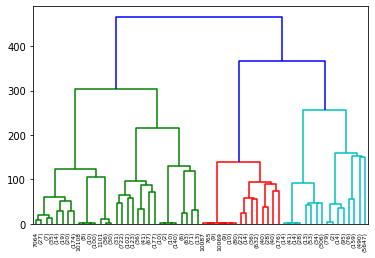

In [101]:
ax = scipy.cluster.hierarchy.dendrogram(reviewlinkage_matrix_euclid, p=5, truncate_mode='level')

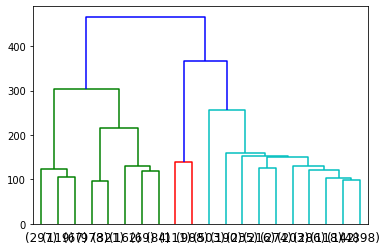

In [102]:
ax = scipy.cluster.hierarchy.dendrogram(reviewlinkage_matrix_euclid, p=20, truncate_mode='lastp')

In [113]:
review_hierarchicalclust = scipy.cluster.hierarchy.fcluster(reviewlinkage_matrix_euclid, 3, 'maxclust')
review_hierarchicalclust

array([2, 3, 3, ..., 2, 3, 3], dtype=int32)

In [114]:
len(review_hierarchicalclust)

10261

In [115]:
review["wald_predictions3"] = review_hierarchicalclust

In [116]:
review

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,kmeans_prediction3,wald_predictions3
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",0,2
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",1,3
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",1,3
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",0,2
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",1,3
...,...,...,...,...,...,...,...,...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","Great, just as expected. Thank to all.",5.0,Five Stars,1405814400,"07 20, 2014",1,3
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014",1,2
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4.0,Good for coated.,1405987200,"07 22, 2014",0,2
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,1404172800,"07 1, 2014",1,3


# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [117]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [118]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [119]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [120]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [121]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [122]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [123]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [124]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(0, 0.6582042), (2, 0.17387961), (8, 0.14765957)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [125]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [126]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(5, 0.9715088)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.971509,0.000000,0.000000,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(1, 0.6297311), (2, 0.012228697), (6, 0.35413...",0.000000,0.629731,0.012229,0.000000,0.000000,0.000000,0.354136,0.000000,0.000000,0.000000
201,04May2006Kennedy8.txt,"[(0, 0.08089544), (1, 0.32858324), (3, 0.36638...",0.080895,0.328583,0.000000,0.366387,0.208179,0.000000,0.000000,0.000000,0.000000,0.014648
301,06Jun2007Kennedy1.txt,"[(0, 0.1099084), (2, 0.54126287), (8, 0.347238...",0.109908,0.000000,0.541263,0.000000,0.000000,0.000000,0.000000,0.000000,0.347239,0.000000
401,08Feb2005Kennedy0.txt,"[(5, 0.9933526)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.993353,0.000000,0.000000,0.000000,0.000000
501,09Nov2005Kennedy11.txt,"[(0, 0.4027599), (5, 0.5585865)]",0.402760,0.000000,0.000000,0.000000,0.000000,0.558586,0.000000,0.000000,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(2, 0.97224844)]",0.000000,0.000000,0.972248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
701,13Jun2006Kennedy1.txt,"[(0, 0.07791362), (2, 0.05234189), (3, 0.36369...",0.077914,0.000000,0.052342,0.363691,0.039163,0.000000,0.451482,0.014122,0.000000,0.000000
801,15Dec2005Kennedy5.txt,"[(0, 0.98967475)]",0.989675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
901,16May2007Kennedy5.txt,"[(0, 0.5577553), (9, 0.401527)]",0.557755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.401527


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [127]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.649356,0.000000,0.193178,0.0,0.000000,0.000000,0.0,0.000000,0.137211,0.000000
1,0.000000,0.000000,0.000000,0.0,0.000000,0.971509,0.0,0.000000,0.000000,0.000000
2,0.153452,0.380809,0.000000,0.0,0.000000,0.000000,0.0,0.460346,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.993994,0.0,0.000000,0.000000,0.000000
4,0.303340,0.000000,0.000000,0.0,0.000000,0.181921,0.0,0.000000,0.000000,0.512953
5,0.000000,0.000000,0.991366,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.0,0.989553,0.000000,0.0,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.0,0.000000,0.967355,0.0,0.000000,0.000000,0.000000
8,0.122603,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.873039,0.000000,0.000000
9,0.000000,0.967152,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


First we can visualize as a stacked bar chart:

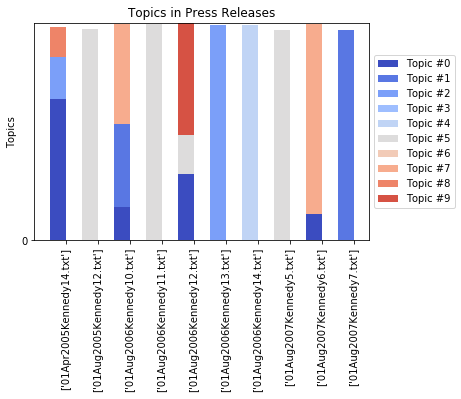

In [128]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

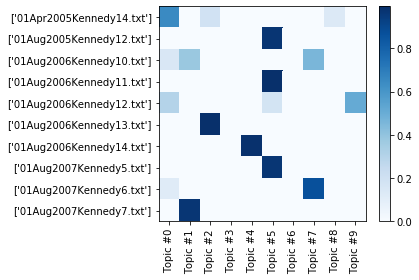

In [129]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [130]:
senlda.show_topic(1)

[('loan', 0.013675327),
 ('worker', 0.0067218794),
 ('lender', 0.0055587683),
 ('fund', 0.0047492394),
 ('rate', 0.0038266566),
 ('woman', 0.0037201354),
 ('attorney', 0.0033755144),
 ('rule', 0.0033564533),
 ('individual', 0.0028135034),
 ('troop', 0.0027551183)]

And if we want to make a dataFrame:

In [131]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fund,loan,worker,fund,worker,worker,worker,loan,fund,wage
1,worker,worker,wage,medicare,minimum,head,fund,lender,unite,worker
2,head,lender,minimum,worker,hear,fund,troop,fund,worker,minimum
3,loan,fund,immigration,company,judge,fda,parent,wage,medicare,fund
4,pension,rate,fund,patient,wage,agency,woman,worker,judge,insurance
5,agency,woman,immigrant,citizen,bankruptcy,patient,asbestos,minimum,company,company
6,company,attorney,asbestos,fail,citizen,standard,victim,victim,senior,coverage
7,unite,rule,association,insurance,company,immigration,area,rate,rule,woman
8,immigration,individual,unite,unite,unite,follow,chip,teacher,standard,hour
9,train,troop,intelligence,loan,woman,border,employer,asbestos,woman,mental


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

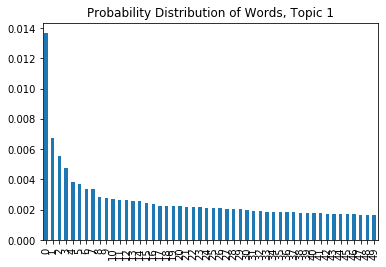

In [132]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [133]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

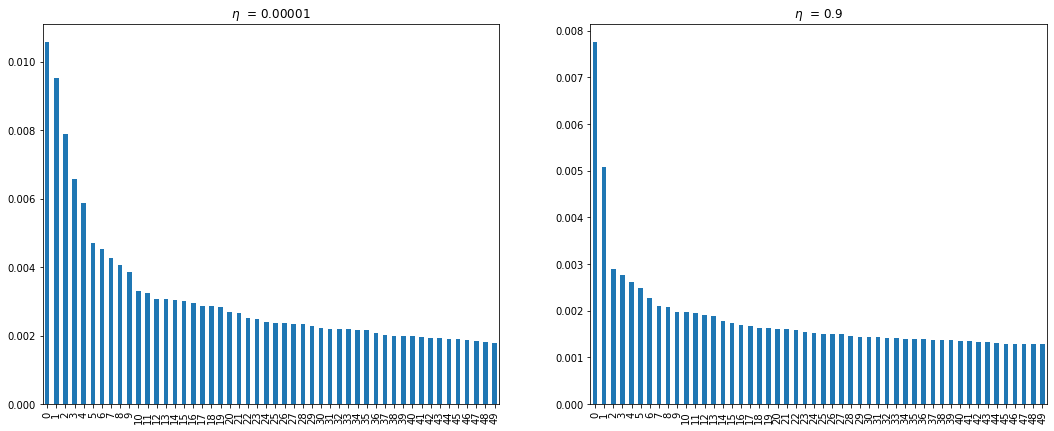

In [134]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [136]:
review.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,kmeans_prediction3,wald_predictions3
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",0,2
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",1,3
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",1,3
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",0,2
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",1,3


In [137]:
review['tokenized_text'] = review['summary'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
review['normalized_tokens'] = review['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [138]:
review.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,kmeans_prediction3,wald_predictions3,tokenized_text,normalized_tokens
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",0,2,[good],[good]
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",1,3,[Jake],[jake]
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",1,3,"[It, Does, The, Job, Well]",[job]
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",0,2,"[GOOD, WINDSCREEN, FOR, THE, MONEY]","[good, windscreen, money]"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",1,3,"[No, more, pops, when, I, record, my, vocals]","[pop, record, vocal]"


In [139]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

review['reduced_tokens'] =review['normalized_tokens'].apply(lambda x: dropMissing(x, review_vectoriser.vocabulary_.keys()))

In [140]:
# creating dictionary
review_dictionary = gensim.corpora.Dictionary(review['reduced_tokens'])

In [141]:
review_corpus = [review_dictionary.doc2bow(text) for text in review['reduced_tokens']]

In [143]:
# serialize
gensim.corpora.MmCorpus.serialize('review.mm', review_corpus)
review_mm = gensim.corpora.MmCorpus('review.mm')

In [144]:
# topic modelling
review_lda = gensim.models.ldamodel.LdaModel(corpus=review_mm, id2word=review_dictionary, num_topics=10, alpha='auto', eta='auto')

In [147]:
# create a df of text and topics
review_ldaDF = pandas.DataFrame({
                'reviewer_id' : review['reviewerID'],
                'review time': review['reviewTime'],
                'topics' : [review_lda[review_dictionary.doc2bow(l)] for l in review['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(review_ldaDF) for i in range(review_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(review_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(review_lda.num_topics):
    review_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

review_ldaDF[1::100]

,reviewer_id,review time,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,A14VAT5EAX3D9S,"03 16, 2013","[(0, 0.09370931), (1, 0.104913294), (2, 0.0981...",0.093709,0.104913,0.098188,0.095832,0.118350,0.100672,0.094129,0.107922,0.095659,0.090625
101,A2NYK9KWFMJV4Y,"06 25, 2013","[(0, 0.030918183), (1, 0.03461479), (2, 0.0323...",0.030918,0.034615,0.032396,0.031618,0.039048,0.033216,0.031057,0.035607,0.031561,0.699963
201,A217QN6PDMKS1A,"10 9, 2013","[(0, 0.046499252), (1, 0.05205718), (2, 0.0487...",0.046499,0.052057,0.048720,0.047550,0.058724,0.049958,0.046705,0.053549,0.047474,0.548764
301,A1VQHH85U7PX0,"06 6, 2009","[(0, 0.046495542), (1, 0.052054584), (2, 0.048...",0.046496,0.052055,0.048719,0.047549,0.562553,0.049950,0.046704,0.053548,0.047463,0.044965
401,ADH0O8UVJOT10,"08 28, 2012","[(0, 0.015421553), (1, 0.017264394), (2, 0.016...",0.015422,0.017264,0.016159,0.015771,0.128335,0.503323,0.155513,0.117557,0.015742,0.014913
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9801,A306NASGVUDFKF,"02 20, 2013","[(0, 0.02315921), (1, 0.7787882), (2, 0.024266...",0.023159,0.778788,0.024266,0.023684,0.029249,0.024881,0.023263,0.026672,0.023641,0.022397
9901,A2O2UE0UTPOB0Q,"12 28, 2012","[(0, 0.046498857), (1, 0.05205831), (2, 0.0487...",0.046499,0.052058,0.048721,0.047552,0.058726,0.553717,0.046707,0.053585,0.047466,0.044968
10001,A2Z1BOQPVQK2M4,"01 15, 2014","[(0, 0.023159144), (1, 0.27314255), (2, 0.0242...",0.023159,0.273143,0.024266,0.274699,0.029249,0.024880,0.277895,0.026672,0.023641,0.022397
10101,AXMYGK3WC8BPP,"06 13, 2014","[(0, 0.35001388), (1, 0.37242496), (5, 0.16119...",0.350014,0.372425,0.000000,0.000000,0.000000,0.161199,0.070356,0.000000,0.000000,0.000000


In [148]:
review_ldaDF['topics'][0]

[(0, 0.046497434),
 (1, 0.05205467),
 (2, 0.048717957),
 (3, 0.04754879),
 (4, 0.05872464),
 (5, 0.04995194),
 (6, 0.04670403),
 (7, 0.5573725),
 (8, 0.047462933),
 (9, 0.044965055)]

Plot topics of first 10 documents

In [150]:
review_ldaDFV = review_ldaDF[:10][['topic_%d' %x for x in range(10)]]
review_ldaDFVisN = review_ldaDF[:10][['reviewer_id']]
review_ldaDFVis = review_ldaDFV.values
review_ldaDFVisNames = review_ldaDFVisN.values
review_ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.046497,0.052055,0.048718,0.047549,0.058725,0.049952,0.046704,0.557373,0.047463,0.044965
1,0.093709,0.104913,0.098188,0.095832,0.118350,0.100672,0.094129,0.107922,0.095659,0.090625
2,0.550327,0.052055,0.048718,0.047549,0.058722,0.049950,0.046704,0.053547,0.047463,0.044965
3,0.023168,0.025937,0.024275,0.023692,0.029260,0.024889,0.023271,0.529895,0.023649,0.271964
4,0.348999,0.034619,0.384339,0.031623,0.039057,0.033220,0.031061,0.035613,0.031565,0.029904
5,0.550301,0.052055,0.048718,0.047549,0.058726,0.049957,0.046704,0.053560,0.047463,0.044966
6,0.820881,0.020734,0.019404,0.018939,0.023389,0.019902,0.018602,0.021329,0.018908,0.017912
7,0.023160,0.025973,0.024268,0.023684,0.029250,0.024881,0.776049,0.026680,0.023656,0.022398
8,0.351061,0.034615,0.032399,0.031620,0.388948,0.033221,0.031057,0.035617,0.031562,0.029901
9,0.523863,0.025931,0.024269,0.275813,0.029253,0.024884,0.023266,0.026677,0.023644,0.022400


In [151]:
review_ldaDFVis[:, 2]

array([0.04871796, 0.09818849, 0.04871802, 0.02427463, 0.38433918,
       0.0487183 , 0.0194044 , 0.02426764, 0.03239869, 0.02426934])

In [152]:
def plot_topics_barchart(senlda, ldaDFVis, ldaDFVisNames, title):
    N = 10
    ind = np.arange(N)
    K = senlda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)


    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title(title)
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

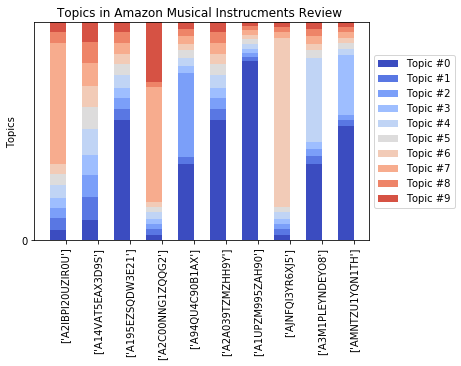

In [156]:
title = 'Topics in Amazon Musical Instrucments Review'
plot_topics_barchart(review_lda, review_ldaDFVis, review_ldaDFVisNames,title)

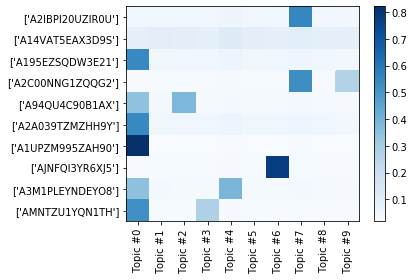

In [158]:
plt.pcolor(review_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(review_ldaDFVis.shape[0])+0.5, review_ldaDFVisNames);
topic_labels = ['Topic #{}'.format(k) for k in range(review_lda.num_topics)]
plt.xticks(np.arange(review_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

Identify topics by top words

In [159]:
topicsDict = {}
for topicNum in range(review_lda.num_topics):
    topicWords = [w for w, p in review_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

review_topic_words = pandas.DataFrame(topicsDict)
review_topic_words

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,awesome,nice,great,little,great,pick,string,good,tuner,love
1,solid,perfect,buy,capo,work,pedal,use,price,guitar,money
2,job,amp,value,great,string,small,product,stand,string,high
3,cheap,like,star,excellent,sound,tone,looper,guitar,snark,thing
4,cable,easy,fine,sound,product,nice,easy,acoustic,electric,wow
5,sound,simple,okay,bad,strap,great,deal,pretty,fantastic,music
6,good,want,bag,cool,quality,bright,excellent,decent,jack,think
7,review,accurate,sturdy,tune,purchase,need,expect,quality,design,fan
8,yup,tune,right,handy,simply,quality,play,string,great,stand
9,latency,stand,stand,portable,simple,light,fender,great,new,action


In [162]:
def word_distribution_bytopic(topic):
    topic_df = pandas.DataFrame(review_lda.show_topic(topic, topn=50))
    plt.figure()
    topic_df.plot.bar(legend = False)
    plt.title('Probability Distribution of Words, Topic {}'.format(topic))
    plt.show()

<Figure size 432x288 with 0 Axes>

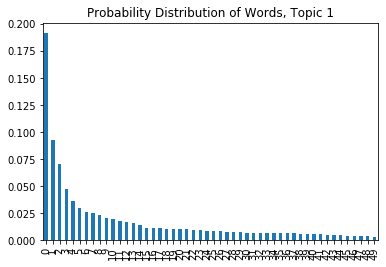

In [163]:
topic = 1
word_distribution_bytopic(topic)

Changing alpha and eta

In [165]:
# Changing eta (Topic-word density - higher means topics are made up of most words in corpus)
review_lda1 = gensim.models.ldamodel.LdaModel(corpus=review_mm, 
                                              id2word=review_dictionary, num_topics=10, eta = 0.00001)
reviewr_lda2 = gensim.models.ldamodel.LdaModel(corpus=review_mm,
                                               id2word=review_dictionary, num_topics=10, eta = 0.9)

In [166]:
review_lda1.show_topic(1, topn=10)

[('work', 0.21078028),
 ('great', 0.14273147),
 ('sound', 0.1353379),
 ('excellent', 0.074453294),
 ('easy', 0.06896016),
 ('fine', 0.035910126),
 ('use', 0.034535274),
 ('bright', 0.026115516),
 ('price', 0.020554783),
 ('quality', 0.01862951)]

In [167]:
review_lda1.show_topic(1, topn=10)

[('work', 0.21078028),
 ('great', 0.14273147),
 ('sound', 0.1353379),
 ('excellent', 0.074453294),
 ('easy', 0.06896016),
 ('fine', 0.035910126),
 ('use', 0.034535274),
 ('bright', 0.026115516),
 ('price', 0.020554783),
 ('quality', 0.01862951)]

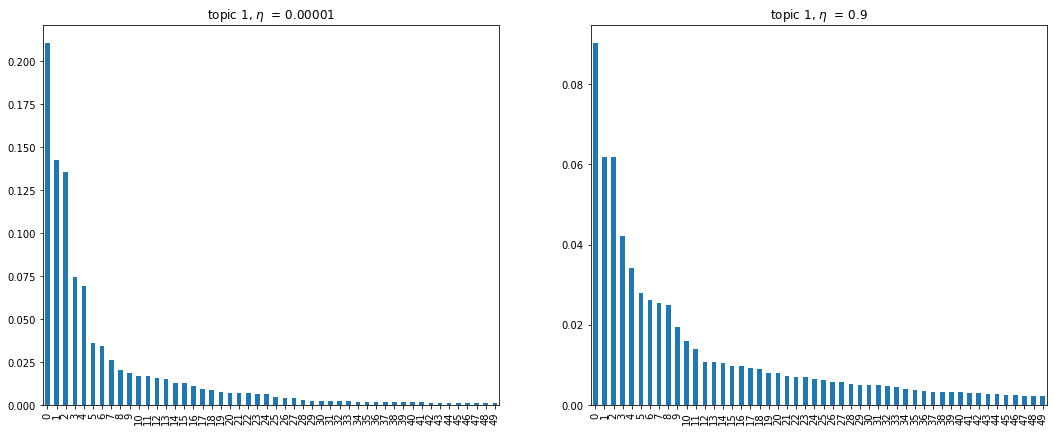

In [170]:
review1_topic_df = pandas.DataFrame(review_lda1.show_topic(1, topn=50))
review2_topic_df = pandas.DataFrame(reviewr_lda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
review1_topic_df.plot.bar(legend = False, ax = ax1, title = 'topic 1, $\eta$  = 0.00001')
review2_topic_df.plot.bar(legend = False, ax = ax2, title = 'topic 1, $\eta$  = 0.9')
plt.show()

# more words in a topic with higher eta.

In [171]:
# Changing alpha (Document-topic density - higher means documents made up of more topics)
review_lda3 = gensim.models.ldamodel.LdaModel(corpus=review_mm, 
                                                 id2word=review_dictionary, num_topics=10, alpha = 0.00001)
review_lda4 = gensim.models.ldamodel.LdaModel(corpus=review_mm, 
                                                 id2word=review_dictionary, num_topics=10, alpha = 0.9)

In [172]:
review_lda3.show_topic(1, topn=10)

[('high', 0.060306404),
 ('little', 0.05075863),
 ('thing', 0.050753314),
 ('good', 0.045992963),
 ('wow', 0.040409923),
 ('tool', 0.03655637),
 ('handy', 0.029512417),
 ('stuff', 0.024605187),
 ('classic', 0.024246164),
 ('purpose', 0.023871295)]

In [173]:
review_lda4.show_topic(1, topn=10)

[('good', 0.08991685),
 ('great', 0.061097343),
 ('price', 0.03178788),
 ('nice', 0.024590781),
 ('string', 0.023673417),
 ('stand', 0.021827877),
 ('work', 0.021469805),
 ('product', 0.019617433),
 ('perfect', 0.018955857),
 ('sound', 0.018291727)]

In [174]:
def create_topicdf(review, review_lda):
    # create a df of text and topics
    review_ldaDF = pandas.DataFrame({
                    'reviewer_id' : review['reviewerID'],
                    'review time': review['reviewTime'],
                    'topics' : [review_lda[review_dictionary.doc2bow(l)] for l in review['reduced_tokens']]
        })

    #Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(review_ldaDF) for i in range(review_lda.num_topics)}

    #Load them into the dict
    for index, topicTuples in enumerate(review_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    #Update the DataFrame
    for topicNum in range(review_lda.num_topics):
        review_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

    return review_ldaDF

In [176]:
# small alpha - less topics
review_lda3DF = create_topicdf(review, review_lda3)

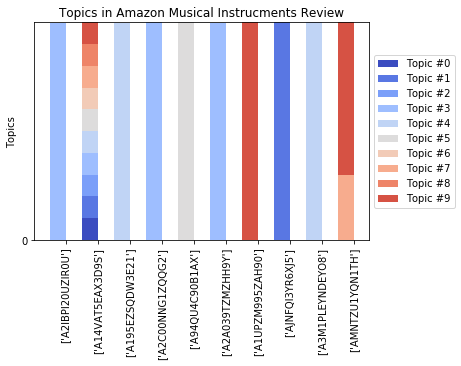

In [180]:
review_ldaDFV = review_lda3DF[:10][['topic_%d' %x for x in range(10)]]
review_ldaDFVisN = review_lda3DF[:10][['reviewer_id']]
review_ldaDFVis = review_ldaDFV.values
review_ldaDFVisNames = review_ldaDFVisN.values

title = 'Topics in Amazon Musical Instrucments Review'
plot_topics_barchart(review_lda3, review_ldaDFVis, review_ldaDFVisNames, title)


In [179]:
# bigger alpha - more topics
review_lda4DF = create_topicdf(review, review_lda4)

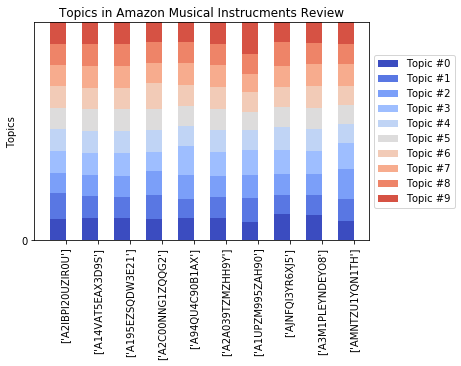

In [182]:
review_ldaDFV = review_lda4DF[:10][['topic_%d' %x for x in range(10)]]
review_ldaDFVisN = review_lda4DF[:10][['reviewer_id']]
review_ldaDFVis = review_ldaDFV.values
review_ldaDFVisNames = review_ldaDFVisN.values

title = 'Topics in Amazon Musical Instrucments Review'
plot_topics_barchart(review_lda4, review_ldaDFVis, review_ldaDFVisNames, title)

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [141]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [142]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [143]:
import zipfile
import pandas as pd

In [144]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [145]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [146]:
soap_dict = {}

In [147]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [148]:
soap_dict.keys()

dict_keys(['One Life to Live', 'Guiding Light', 'Passions', 'Young and Restless', 'As the World Turns', 'General Hospital', 'All My Childen', 'Port Charles', 'Bold and Beautiful', 'Days of Our Lives'])

In [149]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [150]:
i = 0

In [151]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

One Life to Live
Guiding Light
Passions
Young and Restless
As the World Turns
General Hospital
All My Childen
Port Charles
Bold and Beautiful
Days of Our Lives


In [152]:
soap_df

,Soap Name,Tokenized Texts
0,One Life to Live,"[@!Rae, What, She, even, has, a, new, friend, ..."
1,Guiding Light,"[@!Reva, Well, it, 's, very, peaceful, Your, b..."
2,Passions,"[@!Kay, Going, to, get, pregnant, and, I, 'm, ..."
3,Young and Restless,"[@!Sharon, Yeah, I, could, n't, sleep, @!Victo..."
4,As the World Turns,"[@!Katie, Simon, where, are, you, @!Simon, Kat..."
5,General Hospital,"[@!Stefan, I, love, her, @!Jax, No, Cassadine,..."
6,All My Childen,"[@!Liza, You, 're, in, early, @!Ryan, Yeah, I,..."
7,Port Charles,"[@!Jack, There, you, are, you, son, @!Chris, H..."
8,Bold and Beautiful,"[@!Morgan, What, 's, the, matter, Stephanie, Y..."
9,Days of Our Lives,"[@!Philip, Seems, like, every, time, I, look, ..."


Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [153]:
dool = soap_df['Tokenized Texts'][9]

In [154]:
' '.join(dool[0:1500])

"@!Philip Seems like every time I look at you tonight you 're crying @!Chloe Tears of happiness I always thought that when I read Tears of Happiness what a crock But tonight you prove to me that they really do exist @!Philip I just carved our initials on that tree @!Chloe But it was so much more than that You took this angry outsider and you made her feel like a girl in a movie or a book a happy movie or a book @!Philip That 's what you deserve to be What gets me is that you do n't even realize how special you are @!Chloe All my life the word special was code for too weird for words And now here you are this great looking guy with a normal life and you make me believe like you really actually want me around @!Philip Oh that 's only half true @!Chloe Oh I 'm sorry @!Philip Oh no Chloe I want you around forever That 's so true but 's not true at all Except for you there 's nothing normal at all about my life @!Brenda We got to get the labs back on 23 @!Woman I 'll grab them @!Brenda Okay

In [155]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [156]:
import networkx as nx

In [157]:
actor_network = nx.Graph()

In [158]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [159]:
i = 0

In [160]:
all_texts = []

In [161]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

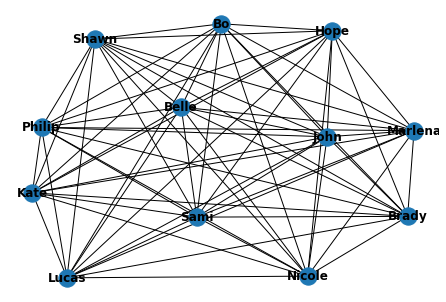

In [162]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [163]:
all_texts[0:10]

[['like', 'time', 'look', 'tonight', 'cry'],
 ['carve', 'initial', 'tree'],
 ['deserve', 'get', 'realize', 'special'],
 ['oh', 'half', 'true'],
 ['oh', 'chloe', 'want', 'forever', 'true', 'true', 'normal', 'life'],
 ['great', 'concentrate', 'search', 'downriver', 'work', 'way'],
 ['right', 'underwater'],
 [],
 ['have', 'come', 'soon', 'hear'],
 ['know', 'guy', 'okay']]

In [164]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [165]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [166]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [167]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [168]:
doollda.show_topics()

[(0,
  '0.130*"na" + 0.120*"gon" + 0.090*"be" + 0.042*"love" + 0.028*"wait" + 0.025*"hmm" + 0.021*"say" + 0.018*"mm" + 0.017*"carrie" + 0.016*"mmm"'),
 (1,
  '0.070*"like" + 0.038*"talk" + 0.036*"dad" + 0.033*"time" + 0.032*"try" + 0.027*"chuckle" + 0.025*"be" + 0.023*"look" + 0.023*"listen" + 0.020*"gun"'),
 (2,
  '0.124*"know" + 0.068*"think" + 0.060*"want" + 0.051*"tell" + 0.025*"go" + 0.016*"come" + 0.014*"be" + 0.013*"mean" + 0.013*"happen" + 0.012*"sami"'),
 (3,
  '0.044*"good" + 0.035*"mean" + 0.031*"think" + 0.028*"stefano" + 0.028*"know" + 0.024*"thing" + 0.021*"believe" + 0.020*"like" + 0.017*"way" + 0.015*"lucas"'),
 (4,
  '0.091*"need" + 0.056*"rafe" + 0.053*"help" + 0.030*"course" + 0.029*"leave" + 0.022*"sydney" + 0.022*"test" + 0.021*"bye" + 0.020*"shoot" + 0.020*"ej"'),
 (5,
  '0.133*"yes" + 0.076*"be" + 0.041*"sorry" + 0.037*"get" + 0.026*"know" + 0.020*"well" + 0.014*"feel" + 0.012*"worry" + 0.010*"mean" + 0.010*"glad"'),
 (6,
  '0.063*"john" + 0.059*"stop" + 0.035*"n

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [169]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [170]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

[(0, 0.04434908), (1, 0.1636655), (2, 0.17168337), (3, 0.07303326), (5, 0.18090375), (7, 0.16316645), (8, 0.049669832), (9, 0.15352708)]
[(0, 0.04564287), (1, 0.15994014), (2, 0.166935), (3, 0.07172846), (5, 0.18492804), (7, 0.16686365), (8, 0.052410174), (9, 0.15154955)]
[(0, 0.045564834), (1, 0.161894), (2, 0.16576263), (3, 0.068994306), (5, 0.18667614), (7, 0.18113962), (8, 0.048315547), (9, 0.14165114)]
[(0, 0.051611815), (1, 0.1611779), (2, 0.1781671), (3, 0.07053677), (5, 0.1791648), (7, 0.16717589), (8, 0.048152395), (9, 0.14401132)]
[(0, 0.047252756), (1, 0.16661952), (2, 0.17018682), (3, 0.06864313), (5, 0.18384352), (7, 0.16521569), (8, 0.05054304), (9, 0.14769368)]
[(0, 0.046162076), (1, 0.15438502), (2, 0.16620177), (3, 0.07256862), (5, 0.1968395), (7, 0.16062519), (8, 0.053342965), (9, 0.14987314)]
[(0, 0.04524269), (1, 0.16827387), (2, 0.17442298), (3, 0.07023772), (5, 0.1848608), (7, 0.16046369), (8, 0.04732241), (9, 0.1491746)]
[(0, 0.045984045), (1, 0.16086726), (2, 0.

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [171]:
from gensim.matutils import kullback_leibler

In [172]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [173]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

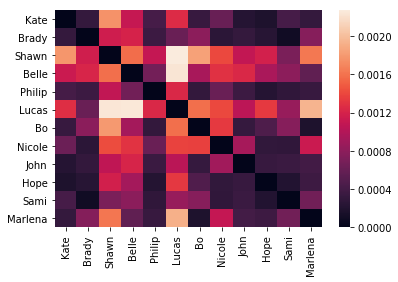

In [174]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [183]:
corpora_address = "/Users/sunny/Documents/CCA Spring 2020/corpora/COHA"

In [184]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


In [185]:
list(coha_texts.keys())[0:5]

['mag_1940_148025.txt',
 'mag_1940_148026.txt',
 'mag_1940_148027.txt',
 'mag_1940_148028.txt',
 'mag_1940_148029.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [186]:
coha_genres = {}
coha_years = {}

In [187]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [188]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [189]:
coha_years.keys()

dict_keys(['1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1815', '1816', '1817', '1818', '1819', '1810', '1811', '1812', '1813', '1814', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1980', '1981', '1982', '1983

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [190]:
import collections

In [191]:
years = []
year_lens = []

In [192]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [193]:
years[0], years[-1]

('1810', '2009')

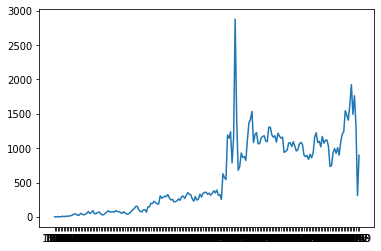

In [194]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [195]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [196]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

NameError: name 'docs_per_year' is not defined

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [18]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [19]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [20]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [41]:
final_corpus= []

In [42]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [43]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [46]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [47]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [48]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [49]:
from gensim.models import ldaseqmodel

In [55]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [64]:
ldaseq.print_topics(time=0)[1]

[('state', 0.009231335276472926),
 ('man', 0.007395542533241843),
 ('great', 0.005407621887489939),
 ('power', 0.00466463108865709),
 ('time', 0.004145275353013492),
 ('government', 0.0038469615335645527),
 ('mr', 0.003784442892543364),
 ('people', 0.0034467994219777665),
 ('law', 0.0034071786078579145),
 ('new', 0.0030027721654430216),
 ('war', 0.002999489239112416),
 ('say', 0.0029620122071219437),
 ('year', 0.0027265764876598106),
 ('country', 0.0026961884570141158),
 ('general', 0.0026385043499987542),
 ('subject', 0.0025921116091278027),
 ('unite', 0.00243013848020865),
 ('interest', 0.0023961925608540803),
 ('mean', 0.002356244385602689),
 ('present', 0.002327481410279418)]

In [65]:
 ldaseq.print_topics(time=4)[1]

[('state', 0.009063458198506274),
 ('great', 0.005281951052175197),
 ('man', 0.0048113539761249395),
 ('power', 0.004484111341699211),
 ('time', 0.004380730260383426),
 ('mr', 0.004363448261206658),
 ('war', 0.0036676379920160007),
 ('government', 0.003660707892751022),
 ('law', 0.003608034898098456),
 ('people', 0.0035690690199701143),
 ('say', 0.0033669920336640846),
 ('new', 0.003254656714598662),
 ('year', 0.0030063559964820033),
 ('right', 0.002722402127793679),
 ('country', 0.0026929936555686994),
 ('unite', 0.0026207546725993914),
 ('president', 0.0026030905455171633),
 ('general', 0.0025967928515510286),
 ('subject', 0.002447981517223704),
 ('office', 0.0024042338715986418)]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [66]:
ldaseq.save("ldaseqmodel")

In [68]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

# Use Dynamic Topic Modelling

In [199]:
review

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,kmeans_prediction3,wald_predictions3,tokenized_text,normalized_tokens,reduced_tokens
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",0,2,[good],[good],[good]
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",1,3,[Jake],[jake],[]
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",1,3,"[It, Does, The, Job, Well]",[job],[job]
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",0,2,"[GOOD, WINDSCREEN, FOR, THE, MONEY]","[good, windscreen, money]","[good, windscreen, money]"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",1,3,"[No, more, pops, when, I, record, my, vocals]","[pop, record, vocal]","[pop, vocal]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","Great, just as expected. Thank to all.",5.0,Five Stars,1405814400,"07 20, 2014",1,3,"[Five, Stars]",[star],[star]
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014",1,2,"[Long, life, and, for, some, players, a, good,...","[long, life, player, good, economic, choice]","[long, life, player, good, choice]"
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4.0,Good for coated.,1405987200,"07 22, 2014",0,2,"[Good, for, coated]","[good, coat]",[good]
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,1404172800,"07 1, 2014",1,3,"[Taylor, Made]",[taylor],[taylor]


In [204]:
type(review['reviewTime'])

pandas.core.series.Series

In [211]:
import re

In [222]:
reviewYear = []
for time in review['reviewTime']:
    year = time[-4:]
    reviewYear.append(year)

In [223]:
reviewYear

['2014',
 '2013',
 '2013',
 '2014',
 '2014',
 '2012',
 '2014',
 '2012',
 '2008',
 '2014',
 '2012',
 '2014',
 '2013',
 '2013',
 '2012',
 '2013',
 '2013',
 '2013',
 '2013',
 '2013',
 '2012',
 '2014',
 '2012',
 '2012',
 '2013',
 '2013',
 '2012',
 '2013',
 '2012',
 '2014',
 '2012',
 '2013',
 '2014',
 '2013',
 '2012',
 '2012',
 '2013',
 '2013',
 '2013',
 '2012',
 '2013',
 '2014',
 '2012',
 '2014',
 '2013',
 '2014',
 '2010',
 '2013',
 '2013',
 '2012',
 '2011',
 '2014',
 '2014',
 '2013',
 '2014',
 '2013',
 '2013',
 '2014',
 '2014',
 '2014',
 '2014',
 '2014',
 '2012',
 '2013',
 '2013',
 '2014',
 '2010',
 '2013',
 '2013',
 '2013',
 '2013',
 '2012',
 '2014',
 '2013',
 '2014',
 '2013',
 '2013',
 '2012',
 '2014',
 '2014',
 '2013',
 '2013',
 '2011',
 '2013',
 '2013',
 '2014',
 '2012',
 '2013',
 '2011',
 '2014',
 '2012',
 '2013',
 '2013',
 '2014',
 '2013',
 '2011',
 '2012',
 '2014',
 '2013',
 '2013',
 '2013',
 '2013',
 '2014',
 '2008',
 '2012',
 '2013',
 '2013',
 '2013',
 '2014',
 '2013',
 '2011',
 

In [224]:
review['reviewYear'] = reviewYear

In [225]:
review

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,kmeans_prediction3,wald_predictions3,tokenized_text,normalized_tokens,reduced_tokens,reviewYear
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",0,2,[good],[good],[good],2014
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",1,3,[Jake],[jake],[],2013
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",1,3,"[It, Does, The, Job, Well]",[job],[job],2013
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",0,2,"[GOOD, WINDSCREEN, FOR, THE, MONEY]","[good, windscreen, money]","[good, windscreen, money]",2014
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",1,3,"[No, more, pops, when, I, record, my, vocals]","[pop, record, vocal]","[pop, vocal]",2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10256,A14B2YH83ZXMPP,B00JBIVXGC,Lonnie M. Adams,"[0, 0]","Great, just as expected. Thank to all.",5.0,Five Stars,1405814400,"07 20, 2014",1,3,"[Five, Stars]",[star],[star],2014
10257,A1RPTVW5VEOSI,B00JBIVXGC,Michael J. Edelman,"[0, 0]",I've been thinking about trying the Nanoweb st...,5.0,"Long life, and for some players, a good econom...",1404259200,"07 2, 2014",1,2,"[Long, life, and, for, some, players, a, good,...","[long, life, player, good, economic, choice]","[long, life, player, good, choice]",2014
10258,AWCJ12KBO5VII,B00JBIVXGC,Michael L. Knapp,"[0, 0]",I have tried coated strings in the past ( incl...,4.0,Good for coated.,1405987200,"07 22, 2014",0,2,"[Good, for, coated]","[good, coat]",[good],2014
10259,A2Z7S8B5U4PAKJ,B00JBIVXGC,"Rick Langdon ""Scriptor""","[0, 0]","Well, MADE by Elixir and DEVELOPED with Taylor...",4.0,Taylor Made,1404172800,"07 1, 2014",1,3,"[Taylor, Made]",[taylor],[taylor],2014


Text(0.5, 1.0, 'Number of reviews by year')

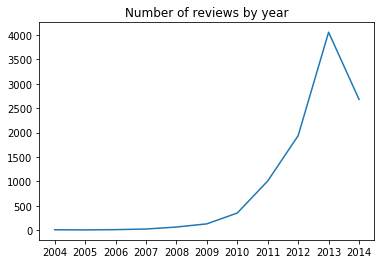

In [234]:
plt.plot(np.sort(review['reviewYear'].unique()), review.groupby('reviewYear').size())
plt.title("Number of reviews by year")

In [235]:
from gensim.models import ldaseqmodel

In [236]:
docs_per_year = list(review.groupby('reviewYear').size())

In [237]:
docs_per_year

[7, 4, 10, 22, 63, 128, 350, 1007, 1936, 4055, 2679]

In [238]:
review_ldaseq = ldaseqmodel.LdaSeqModel(corpus=review_mm, 
                                           id2word=review_dictionary, time_slice=docs_per_year, num_topics=4)

/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/sunny/opt/anaconda3/lib/python3.7/site-packages/gensim/models/ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalar

In [239]:
review_ldaseq.save("review_ldaseq4")

In [240]:
review_ldaseq.print_topics(time=0)

[[('pick', 0.07486453943185012),
  ('great', 0.06867855134984611),
  ('nice', 0.0538629343166057),
  ('product', 0.05187658340170195),
  ('good', 0.04530528186868501),
  ('excellent', 0.042484480041482864),
  ('job', 0.029109181527661107),
  ('awesome', 0.027721435390036447),
  ('need', 0.023037281007668487),
  ('buy', 0.02251749110057669),
  ('price', 0.02142410505053176),
  ('guitar', 0.018675807271666008),
  ('money', 0.01700477381120621),
  ('like', 0.016922379612430278),
  ('expect', 0.013340375405585332),
  ('quality', 0.0122420587001822),
  ('deal', 0.011063459797239777),
  ('right', 0.011004124982694052),
  ('case', 0.010094520906104376),
  ('pedal', 0.00986484306300502)],
 [('good', 0.14724219268069197),
  ('great', 0.05284818954543238),
  ('sound', 0.050977617745615746),
  ('price', 0.04769081889845551),
  ('quality', 0.03726463709228619),
  ('perfect', 0.027583272232491712),
  ('tuner', 0.02716752951216727),
  ('capo', 0.023180291945305687),
  ('look', 0.02065108330980844),


In [241]:
review_ldaseq.print_topics(time=10)

[[('great', 0.06956867138659706),
  ('nice', 0.061198905480340265),
  ('pick', 0.06075432824095352),
  ('product', 0.050298364805452384),
  ('excellent', 0.04527422888725778),
  ('good', 0.04220062840030779),
  ('awesome', 0.030309603641063512),
  ('job', 0.026117934577285493),
  ('buy', 0.02478166239444475),
  ('price', 0.02466813863842598),
  ('need', 0.022180264203378087),
  ('guitar', 0.018530282973238027),
  ('like', 0.01773596909030945),
  ('money', 0.01767774400875074),
  ('expect', 0.014436705522804318),
  ('quality', 0.012631324882962843),
  ('deal', 0.012558553056681541),
  ('right', 0.010785836348249488),
  ('case', 0.010448031651543982),
  ('pedal', 0.01015240145524797)],
 [('good', 0.09761360565698712),
  ('tuner', 0.07078332873515723),
  ('great', 0.06843345022156806),
  ('sound', 0.051306725098825334),
  ('price', 0.04929159726109168),
  ('quality', 0.029694419104053994),
  ('perfect', 0.027670252343799055),
  ('capo', 0.020629615322774117),
  ('look', 0.0178674514742902

Divergence over time